In [1]:
import pandas as pd

In [2]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
import numpy as np
import json
#from scipy import sparse
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#import joblib
#from spacy.lang.ru import Russian
#from gensim.models import KeyedVectors
import torch
#from transformers import AutoTokenizer, AutoModel
#! -m spacy download ru_core_news_sm
#import ru_core_news_sm

In [3]:
len('Зашли в"аппетит" случайно.Не смотря на то,что был будний день( вторник 14 сентября) и достаточно много народа, все же решили остаться.нас ')

138

In [4]:
data = pd.read_csv('train_formated_reviews.csv', index_col='Unnamed: 0')

In [5]:
data

,text_id,sentence,word,lemma,POS,head,cat01,aspect,start,end
1,3976,"День 8-го марта прошёл, можно и итоги подвести.",День,день,NOUN,прошёл,0,0,-,-
2,3976,"День 8-го марта прошёл, можно и итоги подвести.",8-го,8-й,ADJ,День,0,0,-,-
3,3976,"День 8-го марта прошёл, можно и итоги подвести.",марта,март,NOUN,8-го,0,0,-,-
4,3976,"День 8-го марта прошёл, можно и итоги подвести.",прошёл,пройти,VERB,прошёл,0,0,-,-
5,3976,"День 8-го марта прошёл, можно и итоги подвести.",",",",",PUNCT,можно,0,0,-,-
...,...,...,...,...,...,...,...,...,...,...
47030,16630,"Спасибо персоналу, ему удается создать ощущени...",),),PUNCT,Спасибо,0,0,-,-
47031,16630,"Спасибо персоналу, ему удается создать ощущени...",),),PUNCT,Спасибо,0,0,-,-
47032,16630,"Спасибо персоналу, ему удается создать ощущени...",),),PUNCT,Спасибо,0,0,-,-
47033,16630,"Спасибо персоналу, ему удается создать ощущени...",),),PUNCT,Спасибо,0,0,-,-


In [6]:
set(data.aspect)

{'0', 'Food', 'Interior', 'Price', 'Service', 'Whole'}

In [7]:
data_for_train = []
lemms = list(data['lemma'])
asps = list(data['aspect'])
first_el = 'День 8-го марта прошёл, можно и итоги подвести.'
#first_el = 
one_sentence = []
one_aspect = []
for i, el in enumerate(data.sentence):
    if el != first_el:
        data_for_train.append((one_sentence, one_aspect))
        one_sentence = []
        one_aspect = []
        first_el = el
    one_sentence.append(lemms[i])
    one_aspect.append(asps[i])
data_for_train.append((one_sentence, one_aspect))

In [8]:
data_for_train[-2]

(['мочь', 'сказать', 'одно', ',', 'я', 'была', 'приятно', 'удивить', '!'],
 ['0', '0', '0', '0', '0', '0', '0', '0', '0'])

In [9]:
data_for_train[-1]

(['спасибо',
  'персонал',
  ',',
  'ему',
  'удаваться',
  'создать',
  'ощущение',
  ',',
  'что',
  'этот',
  'ресторан',
  '-',
  'особенный',
  'место',
  'где',
  'каждый',
  'чувствовать',
  'себя',
  'долгожданный',
  'гость',
  '!',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')',
  ')'],
 ['0',
  'Service',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  'Whole',
  '0',
  '0',
  'Whole',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'])

In [10]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

In [11]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix:
            idxs.append(to_ix[w])
        else:
            idxs.append(random.randint(0, 3800))
    
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [12]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [14]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 300
HIDDEN_DIM = 32

# Make up some training data
training_data = data_for_train[:-600]

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

tag_to_ix = {'0':0, 'Food':1, 'Interior':2, 'Price':3, 'Service':4, 'Whole':5, '<START>':6, '<STOP>':7}

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
test_f1 = []
losses_train = []
# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(7):
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)
        losses_train.append(loss)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

# Check predictions after training


100%|█████████████████████████████████████████████████████| 2390/2390 [02:27<00:00, 16.15it/s]


In [15]:
set(data.aspect)

{'0', 'Food', 'Interior', 'Price', 'Service', 'Whole'}

In [16]:
len(word_to_ix)

3885

In [17]:
import random

In [20]:
answers_test = []
losses_test = []
with torch.no_grad():
    for sentence, tags in tqdm(data_for_train[-600:]):
        #print(tags)
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance=

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        answers_test.append(model(sentence_in))

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)
        losses_test.append(loss)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()

100%|███████████████████████████████████████████████████████| 600/600 [00:12<00:00, 49.60it/s]


In [18]:
#мы могли бы сказать, что мы переобучились. Но мы не переобучились -- мы можем в предсказание придуманного случайного
sentence = 'мы ходить в ресторан " армения " , горячий быть вкусно, десерт и сервис быть не очень'.split()
sentence_in = prepare_sequence(sentence, word_to_ix)
model(sentence_in)

(tensor(153.5010, grad_fn=<SelectBackward0>),
 [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0])

In [21]:
print(prepare_sequence(data_for_train[-600:-598][0][1], tag_to_ix))

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 5, 0])


In [22]:
ans_all = []
pre_all = []
ans = []
pre = []
with torch.no_grad():
    for i, el in enumerate(answers_test[-600:]):
        pre_all.extend(prepare_sequence(data_for_train[-600:][i][1], tag_to_ix))
        ans_all.extend(el[1])
        pre.append(prepare_sequence(data_for_train[-600:][i][1], tag_to_ix))
        ans.append(el[1])

In [35]:
int(pre_all[0])

0

In [36]:
from 
([int(i) for i in pre_all])

{0, 1, 2, 3, 4, 5}

In [21]:
print(ans[3])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0]


In [22]:
print([int(i) for i in pre[3]])

[0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0]


In [23]:
from sklearn.metrics import *

In [24]:
accuracy_score(ans_all, pre_all)

0.9418674099143938

In [25]:
print(f1_score(ans_all, pre_all, average='weighted'))

0.9468782627742184


In [26]:
import matplotlib.pyplot as plt

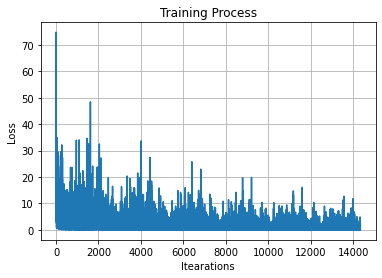

In [27]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot([loss.item() for loss in losses_train])

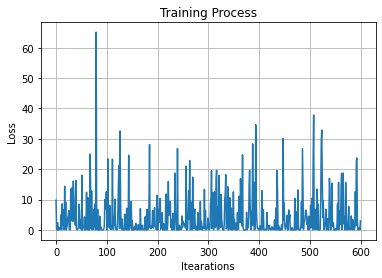

In [28]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot([loss.item() for loss in losses_test])

In [ ]:
precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))

In [29]:
model

BiLSTM_CRF(
  (word_embeds): Embedding(17, 300)
  (lstm): LSTM(300, 16, bidirectional=True)
  (hidden2tag): Linear(in_features=32, out_features=5, bias=True)
)

In [35]:
len(data_for_train[:-600])

2390